In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
orders = pd.read_csv('/content/drive/MyDrive/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/products.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/order_products__prior.csv', nrows=3421083)

In [ ]:
orders.shape

(3421083, 7)

In [ ]:
products.shape

(49688, 4)

In [ ]:
order_products_prior.shape

(3421083, 4)

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
order_products = pd.merge(order_products_prior, products, on='product_id', how='inner')
merged_data = pd.merge(order_products, orders, on='order_id', how='inner')

merged_data.shape

(3421083, 13)

In [ ]:
merged_data.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0


In [ ]:
merged_data.to_csv('merged_orders_products.csv', index=False)

Caractéristiques basées sur la date

In [ ]:
# Création d'une colonne order_date à partir de days_since_prior_order
# Définir la date de référence
reference_date = pd.to_datetime('2017-01-01')

merged_data['order_date'] = reference_date + pd.to_timedelta(merged_data['days_since_prior_order'], unit='D')

Nettyage des données

In [ ]:
merged_data.isnull().sum()

merged_data = merged_data.dropna()

In [ ]:
merged_data.isna().sum()

,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
product_name,0
aisle_id,0
department_id,0
user_id,0
eval_set,0
order_number,0


In [ ]:
merged_data.dtypes

,0
order_id,int64
product_id,int64
add_to_cart_order,int64
reordered,int64
product_name,object
aisle_id,int64
department_id,int64
user_id,int64
eval_set,object
order_number,int64


Normalisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['days_since_prior_order', 'order_hour_of_day', 'add_to_cart_order', 'reordered', 'aisle_id', 'department_id', 'order_number']
scaler = MinMaxScaler()
merged_data[columns_to_normalize] = scaler.fit_transform(merged_data[columns_to_normalize])

merged_data[columns_to_normalize].describe()

,days_since_prior_order,order_hour_of_day,add_to_cart_order,reordered,aisle_id,department_id,order_number
count,3.201822e+06,3.201822e+06,3.201822e+06,3.201822e+06,3.201822e+06,3.201822e+06,3.201822e+06
mean,3.700655e-01,5.830318e-01,5.831909e-02,6.299129e-01,5.276770e-01,4.462745e-01,1.677195e-01
std,2.923145e-01,1.846916e-01,5.666943e-02,4.828278e-01,2.872424e-01,3.141499e-01,1.815483e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.666667e-01,4.347826e-01,1.587302e-02,0.000000e+00,2.255639e-01,1.500000e-01,4.123711e-02
50%,2.666667e-01,5.652174e-01,3.968254e-02,1.000000e+00,6.165414e-01,4.000000e-01,1.030928e-01
75%,5.000000e-01,6.956522e-01,7.936508e-02,1.000000e+00,7.969925e-01,7.500000e-01,2.371134e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Création des séquences pour LSTM

In [ ]:
daily_demand = merged_data.groupby(['order_date', 'product_id']).agg(
    demand=('product_id', 'size'),
    order_hour_of_day=('order_hour_of_day', 'mean')
).reset_index()

daily_demand.head()

,order_date,product_id,demand,order_hour_of_day
0,2017-01-01,1,9,0.642512
1,2017-01-01,10,5,0.686957
2,2017-01-01,12,1,0.695652
3,2017-01-01,23,1,0.695652
4,2017-01-01,25,1,0.608696


In [ ]:
def create_sequences_with_features(data, time_steps=9):
    X, y = [], []

    feature_columns = ['demand', 'order_hour_of_day']

    for product_id in data['product_id'].unique():
        product_data = data[data['product_id'] == product_id]

        for i in range(len(product_data) - time_steps):
            X.append(product_data.iloc[i:i+time_steps][feature_columns].values)
            y.append(product_data.iloc[i+time_steps]['demand'])

    return np.array(X), np.array(y)

X, y = create_sequences_with_features(daily_demand, time_steps=9)

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (190120, 9, 2)
Shape of y: (190120,)


# Construction du modèle

Préparation des données

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

Construction du modèle LSTM

In [ ]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout

model = Sequential()

#couche LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

#couche Dense
model.add(Dense(units=25, activation='relu'))

#Couche de sortie avec activation linéaire pour la régression
model.add(Dense(units=1, activation='linear'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,901 (46.49 KB)

 Trainable params: 11,901 (46.49 KB)

 Non-trainable params: 0 (0.00 B)

Entraînement du modèle

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 875.1332 - val_loss: 616.6830
Epoch 2/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 770.0405 - val_loss: 604.8455
Epoch 3/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 659.6872 - val_loss: 542.7581
Epoch 4/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 631.8331 - val_loss: 590.5423
Epoch 5/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 735.9080 - val_loss: 601.6014
Epoch 6/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 1050.5825 - val_loss: 507.9334
Epoch 7/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 711.5555 - val_loss: 536.9692
Epoch 8/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 915.5459 - val_loss: 534.7609
Epoch 9/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 744.8866 - val_loss: 570.4241
Epoch 10/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 656.6476 - val_loss: 531.0815
Epoch 11/20
1902/1902 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 734.

Évaluation du modèle

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.9961
Test Loss: 5.137160778045654


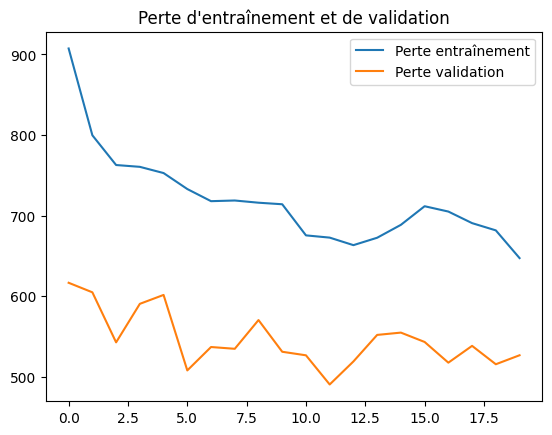

In [ ]:
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Perte d\'entraînement et de validation')
plt.legend()
plt.show()

Métriques RMSE, MAE

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE): {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Root Mean Squared Error (RMSE): 2.266531085653017
Mean Absolute Error (MAE): 1.6937611103057861


Visualisation des valeurs réelles vs prédites

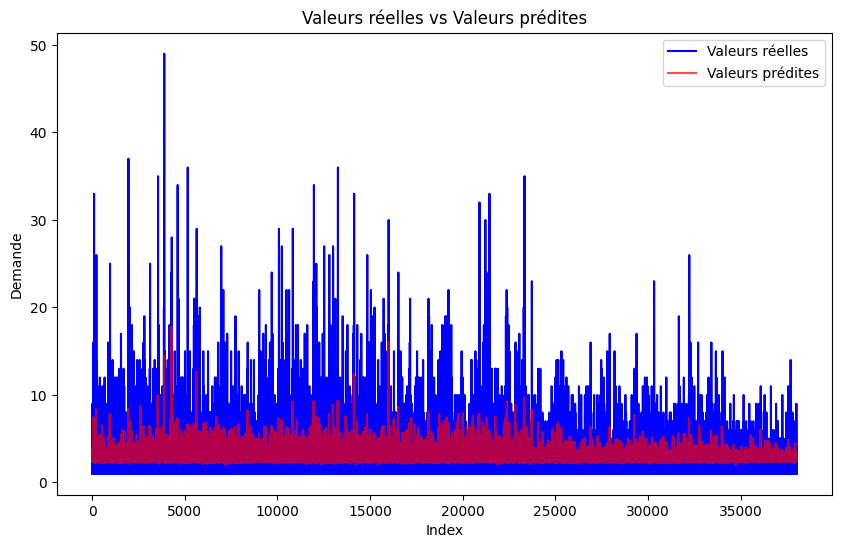

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Valeurs réelles', color='blue')
plt.plot(y_pred, label='Valeurs prédites', color='red', alpha=0.7)
plt.title('Valeurs réelles vs Valeurs prédites')
plt.xlabel('Index')
plt.ylabel('Demande')
plt.legend()
plt.show()
